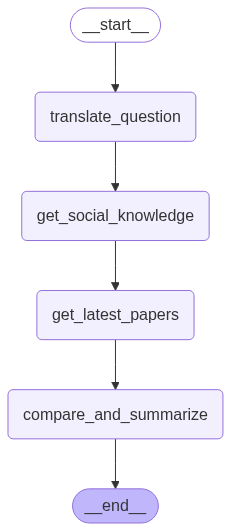

In [33]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
from langgraph.graph import StateGraph, END
from langchain_openai import OpenAIEmbeddings
from langchain_community.chat_models import ChatOpenAI as LCChatOpenAI
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_chroma import Chroma
from langchain.agents import create_openai_functions_agent, Tool, AgentExecutor
from langchain.prompts import ChatPromptTemplate as LCChatPromptTemplate
from textwrap import dedent
from typing import TypedDict

# ✅ 상태 정의
class CompareState(TypedDict):
    """
    비교 및 요약 작업을 위한 상태를 정의합니다.
    """
    question: str
    translated_question: str
    social_knowledge: str
    latest_docs: list
    k_value: int
    final_answer: str

# ✅ 모델 정의
model = LCChatOpenAI(model="gpt-4o", temperature=0)
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

# ✅ 프롬프트 정의
COMPARE_PROMPT = LCChatPromptTemplate.from_messages([
    ("system", dedent("""
    당신은 전문 의료 정보 요약가입니다.
    아래 사용자 질문, 사회통념 정보, 최신 의학 논문 정보를 바탕으로,
    최신 연구 결과가 기존 사회통념과 어떻게 다른지 비교하고 종합적인 한글 요약을 작성하세요.
    사회통념이나 최신 논문 정보가 없다면 해당 부분은 '정보 없음'이라고 작성하세요.
    """)),
    ("human", dedent("""
    사용자 질문: {question}

    [사회통념 정보]
    {social_knowledge}

    [최신 논문 정보]
    {latest_docs}

    위 내용을 바탕으로 상세하고 쉽게 이해할 수 있는 한글 요약을 작성하세요.
    """))
])

# ✅ 노드 정의

def translate_question(state: CompareState) -> CompareState:
    """
    사용자 질문을 영어로 번역하는 노드.
    """
    translate_prompt = f"Translate the following Korean medical question into English: {state['question']}"
    translated = model.invoke(translate_prompt).content
    state["translated_question"] = translated
    return state

def agent_search(state: CompareState) -> CompareState:
    """
    Wikipedia를 통해 사회 통념 정보를 검색하는 Agent 노드.
    """
    wiki_wrapper = WikipediaAPIWrapper()
    wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

    tools = [Tool(name="Wikipedia", func=wiki_tool.run, description="사회통념 검색")]

    AGENT_PROMPT = LCChatPromptTemplate.from_messages([
        ("system", "너는 똑똑한 전문가야. 필요한 정보를 찾기 위해 도구를 사용해. 정보를 찾은 후에는 해당 정보를 한국어로 요약해서 'output'에 넣어줘."),
        ("human", "{input}\n\n{agent_scratchpad}")
    ])

    agent = create_openai_functions_agent(model, tools, prompt=AGENT_PROMPT)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=False)

    result = executor.invoke({"input": f"Search for common knowledge about: {state['translated_question']}. Summarize the findings in Korean."})
    state["social_knowledge"] = result["output"]
    return state

def get_latest_papers(state: CompareState) -> CompareState:
    """
    Chroma Vector Store에서 최신 논문을 검색하는 노드.
    """
    try:
        retriever = Chroma(
            collection_name="paper_db",
            persist_directory="vector_store/chroma", # 실제 데이터가 있는 경로 확인 필요
            embedding_function=embedding_model
        ).as_retriever(search_kwargs={"k": state["k_value"]})

        docs = retriever.invoke(state["translated_question"])
        contents = [doc.page_content for doc in docs]
        state["latest_docs"] = contents
    except Exception: # 오류 발생 시 빈 리스트로 설정하여 다음 단계 진행
        state["latest_docs"] = []
    return state

def increase_k(state: CompareState) -> CompareState:
    """
    최신 논문 검색 결과가 없을 경우 k 값을 증가시키는 노드.
    """
    state["k_value"] += 2
    return state

def should_retry_latest(state: CompareState) -> str:
    """
    최신 논문 검색 결과가 충분한지 확인하는 조건 함수.
    결과가 없거나 부족하면 'increase_k'로, 그렇지 않으면 'compare_and_summarize'로 분기.
    """
    if len(state["latest_docs"]) <= 1 and state["k_value"] < 10:
        return "increase_k"
    else:
        return "compare_and_summarize"

def compare_and_summarize(state: CompareState) -> CompareState:
    """
    사회 통념과 최신 논문 정보를 비교하여 최종 요약을 생성하는 노드.
    """
    social_knowledge_content = state["social_knowledge"] if state["social_knowledge"] else "정보 없음"
    latest_docs_content = "\n\n".join(state["latest_docs"]) if state["latest_docs"] else "정보 없음"

    prompt_value = COMPARE_PROMPT.format(
        question=state["question"],
        social_knowledge=social_knowledge_content,
        latest_docs=latest_docs_content
    )
    response = model.invoke(prompt_value)
    state["final_answer"] = response.content
    return state


# ✅ 그래프 구성
def build_compare_graph():
    """
    LangGraph 워크플로우를 구성합니다.
    """
    workflow = StateGraph(CompareState)

    # 노드 추가
    workflow.add_node("translate_question", translate_question)
    workflow.add_node("agent_search", agent_search)
    workflow.add_node("get_latest_papers", get_latest_papers)
    workflow.add_node("increase_k", increase_k)
    workflow.add_node("compare_and_summarize", compare_and_summarize)

    # 시작점 설정
    workflow.set_entry_point("translate_question")

    # 엣지 연결 (노드 간의 흐름)
    workflow.add_edge("translate_question", "agent_search")
    workflow.add_edge("agent_search", "get_latest_papers")

    # 조건부 분기 추가: 최신 논문 검색 결과에 따라 다음 노드 결정
    workflow.add_conditional_edges(
        "get_latest_papers",
        should_retry_latest,
        {
            "increase_k": "increase_k",
            "compare_and_summarize": "compare_and_summarize"
        }
    )
    workflow.add_edge("increase_k", "get_latest_papers")
    workflow.add_edge("compare_and_summarize", END)

    return workflow.compile()

# ✅ 실행 예제
if __name__ == "__main__":
    graph = build_compare_graph()

    initial_state = {
        "question": "비타민 C를 과다 복용하면 어떤 부작용이 있나요?",
        "translated_question": "",
        "social_knowledge": "",
        "latest_docs": [],
        "k_value": 3,
        "final_answer": ""
    }

    result = graph.invoke(initial_state)

    print("\n\n=== 🟢 최종 한글 응답 ===")
    print(result["final_answer"])
    print("======================\n")



> Entering new AgentExecutor chain...

Invoking: `Wikipedia` with `side effects of overdosing on vitamin C`


Page: Vitamin C megadosage
Summary: Vitamin C megadosage is a term describing the consumption or injection of vitamin C (ascorbic acid) in doses well beyond the current United States Recommended Dietary Allowance of 90 milligrams per day, and often well beyond the tolerable upper intake level of 2,000 milligrams per day. There is no strong scientific evidence that vitamin C megadosage helps to cure or prevent cancer, the common cold, or some other medical conditions.
Historical advocates of vitamin C megadosage include Linus Pauling, who won the Nobel Prize in Chemistry in 1954. Pauling argued that because humans and other primates lack a functional form of L-gulonolactone oxidase, an enzyme required to make vitamin C that is functional in almost all other mammals, plants, insects, and other life forms, humans have developed a number of adaptations to cope with the relative d